<a href="https://colab.research.google.com/github/xbeafraid1/ILTAL/blob/main/Python_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU가 쓰고 싶어요


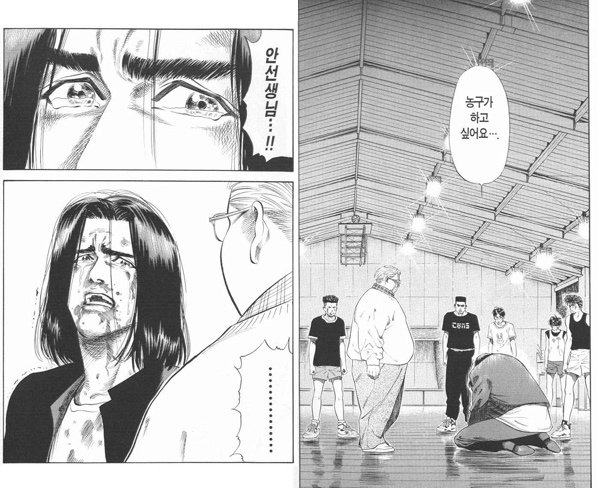


In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 20693 (delta 41), reused 36 (delta 15), pack-reused 20602
Receiving objects: 100% (20693/20693), 16.28 MiB | 33.40 MiB/s, done.
Resolving deltas: 100% (15081/15081), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728)

In [2]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import torch
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from pandas import DataFrame, concat
import torch
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!pip install import_ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=845a5daf7a1604987334a01dee958dcf131d8bfb60cc560bf00006369bac88b4
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp /content/drive/MyDrive/Jupyter/unlimited_power/합치기_전_임시작업/MJ/rg_defs.ipynb .
import rg_defs as RG

importing Jupyter notebook from rg_defs.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_use = ['Time', 'DHI','DNI','RH','T','TARGET']

n_features = len(what_to_use)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [8]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [9]:
df_test = []

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    testset = RG.drop_clms(temp)
    testset2 = RG.series_to_supervised(testset, n_days, dropnan=False)
    testset3 = RG.minmax_scaler(testset2, train=False)
    testset4 = testset3.iloc[-ticks:, :]
    df_test.append(testset4)

X_test = pd.concat(df_test)
X_test = X_test.iloc[:, :n_obs]
X_test.shape

(3888, 864)

In [10]:
X_test

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
288,0.000000,0.0,0.0,0.847776,0.338983,0.0,0.021277,0.0,0.0,0.878049,0.314607,0.0,0.042553,0.0,0.0,0.943472,0.292135,0.0,0.063830,0.0,0.0,0.950359,0.290503,0.0,0.085106,0.0,0.0,1.000000,0.284916,0.0,0.106383,0.0,0.0,1.000000,0.284916,0.0,0.127660,0.0,0.0,0.978049,...,0.000000,0.990883,0.259067,0.000000,0.893617,0.000000,0.000000,0.979635,0.261538,0.000000,0.914894,0.000000,0.000000,0.979635,0.265306,0.000000,0.936170,0.000000,0.000000,0.970874,0.272727,0.000000,0.957447,0.0,0.0,0.970874,0.280000,0.0,0.978723,0.0,0.0,0.963533,0.283582,0.0,1.000000,0.0,0.0,0.970755,0.282178,0.0
289,0.021277,0.0,0.0,0.878049,0.310734,0.0,0.042553,0.0,0.0,0.943472,0.292135,0.0,0.063830,0.0,0.0,0.950359,0.286517,0.0,0.085106,0.0,0.0,1.000000,0.284916,0.0,0.106383,0.0,0.0,1.000000,0.284916,0.0,0.127660,0.0,0.0,0.978049,0.284916,0.0,0.148936,0.0,0.0,0.971019,...,0.000000,0.979635,0.253886,0.000000,0.914894,0.000000,0.000000,0.979635,0.261538,0.000000,0.936170,0.000000,0.000000,0.970874,0.265306,0.000000,0.957447,0.000000,0.000000,0.970874,0.272727,0.000000,0.978723,0.0,0.0,0.963533,0.280000,0.0,1.000000,0.0,0.0,0.970755,0.278607,0.0,0.000000,0.0,0.0,0.958087,0.277228,0.0
290,0.042553,0.0,0.0,0.943472,0.288136,0.0,0.063830,0.0,0.0,0.950359,0.286517,0.0,0.085106,0.0,0.0,1.000000,0.280899,0.0,0.106383,0.0,0.0,1.000000,0.284916,0.0,0.127660,0.0,0.0,0.978049,0.284916,0.0,0.148936,0.0,0.0,0.971019,0.290503,0.0,0.170213,0.0,0.0,0.922525,...,0.000000,0.979635,0.253886,0.000000,0.936170,0.000000,0.000000,0.970874,0.261538,0.000000,0.957447,0.000000,0.000000,0.970874,0.265306,0.000000,0.978723,0.000000,0.000000,0.963533,0.272727,0.000000,1.000000,0.0,0.0,0.970755,0.275000,0.0,0.000000,0.0,0.0,0.958087,0.273632,0.0,0.021277,0.0,0.0,0.965309,0.272277,0.0
291,0.063830,0.0,0.0,0.950359,0.282486,0.0,0.085106,0.0,0.0,1.000000,0.280899,0.0,0.106383,0.0,0.0,1.000000,0.280899,0.0,0.127660,0.0,0.0,0.978049,0.284916,0.0,0.148936,0.0,0.0,0.971019,0.290503,0.0,0.170213,0.0,0.0,0.922525,0.301676,0.0,0.191489,0.0,0.0,0.916930,...,0.000000,0.970874,0.253886,0.000000,0.957447,0.000000,0.000000,0.970874,0.261538,0.000000,0.978723,0.000000,0.000000,0.963533,0.265306,0.000000,1.000000,0.000000,0.000000,0.970755,0.267677,0.000000,0.000000,0.0,0.0,0.958087,0.270000,0.0,0.021277,0.0,0.0,0.965309,0.268657,0.0,0.042553,0.0,0.0,0.946128,0.267327,0.0
292,0.085106,0.0,0.0,1.000000,0.276836,0.0,0.106383,0.0,0.0,1.000000,0.280899,0.0,0.127660,0.0,0.0,0.978049,0.280899,0.0,0.148936,0.0,0.0,0.971019,0.290503,0.0,0.170213,0.0,0.0,0.922525,0.301676,0.0,0.191489,0.0,0.0,0.916930,0.307263,0.0,0.212766,0.0,0.0,0.880057,...,0.000000,0.970874,0.253886,0.000000,0.978723,0.000000,0.000000,0.963533,0.261538,0.000000,1.000000,0.000000,0.000000,0.970755,0.260204,0.000000,0.000000,0.000000,0.000000,0.958087,0.262626,0.000000,0.021277,0.0,0.0,0.965309,0.265000,0.0,0.042553,0.0,0.0,0.946128,0.263682,0.0,0.063830,0.0,0.0,0.946128,0.267327,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [11]:
# drop_clms 함수를 이용하여 쓰지 않는 데이터 분리하기

dataset = RG.drop_clms(raw_data)
dataset2 = RG.series_to_supervised(dataset, n_days)
dataset3 = RG.minmax_scaler(dataset2)
dataset3

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.000000,0.0,0.0,0.665404,0.129630,0.0,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,...,0.129630,0.0,0.893617,0.0,0.0,0.814955,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.0,0.0
145,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,...,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.0,0.0
146,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,...,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.0,0.0
147,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,...,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.0,0.0
148,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,0.148148,0.0,0.212766,0.0,0.0,0.715832,...,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.063830,0.0,0.0,0.692349,0.111111,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,0.914894,0.0,0.0,0.836057,0.203704,0.0,0.936170,0.0,0.0,0.808029,0.203704,0.0,0.957447,0.0,0.0,0.807921,0.203704,0.0,0.978723,0.0,0.0,0.795910,0.203704,0.0,1.

In [12]:
# train_X, train_y, test_X, test_y로 분리하는 함수.

X_train_1, X_valid_1, Y_train_1,  Y_valid_1, X_train_2, X_valid_2, Y_train_2, Y_valid_2 = RG.seperator(dataset3)

In [13]:
X_train_1

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
1555,0.404255,0.301136,0.112370,0.595282,0.444444,0.189726,0.425532,0.361742,0.127479,0.558381,0.462963,0.232928,0.446809,0.397727,0.072710,0.558056,0.462963,0.231049,0.468085,0.179924,0.000000,0.564225,0.462963,0.089226,0.489362,0.482955,0.140699,0.563792,0.462963,0.313701,0.510638,0.412879,0.028329,0.568986,0.462963,0.219779,0.531915,0.473485,0.071766,0.568661,...,0.000000,0.653934,0.314815,0.000000,0.276596,0.000000,0.000000,0.601234,0.333333,0.000000,0.297872,0.000000,0.000000,0.619738,0.333333,0.000000,0.319149,0.028409,0.000000,0.523753,0.351852,0.014089,0.340426,0.092803,0.000000,0.536414,0.370370,0.046025,0.361702,0.066288,0.000000,0.536522,0.388889,0.032874,0.382979,0.142045,0.000000,0.496808,0.407407,0.070444
38121,0.191489,0.000000,0.000000,0.543339,0.296296,0.000000,0.212766,0.000000,0.000000,0.529380,0.296296,0.000000,0.234043,0.000000,0.000000,0.529272,0.296296,0.000000,0.255319,0.000000,0.000000,0.518883,0.296296,0.000000,0.276596,0.000000,0.000000,0.435234,0.333333,0.000000,0.297872,0.053030,0.366383,0.434585,0.351852,0.056357,0.319149,0.081439,0.592068,0.398009,...,0.000000,0.554810,0.407407,0.000000,0.063830,0.000000,0.000000,0.601666,0.407407,0.000000,0.085106,0.000000,0.000000,0.568012,0.407407,0.000000,0.106383,0.000000,0.000000,0.616059,0.388889,0.000000,0.127660,0.000000,0.000000,0.572557,0.388889,0.000000,0.148936,0.000000,0.000000,0.572341,0.370370,0.000000,0.170213,0.000000,0.000000,0.551564,0.370370,0.000000
4783,0.659574,0.251894,0.672332,0.114273,0.648148,0.492100,0.680851,0.253788,0.550519,0.118277,0.648148,0.382223,0.702128,0.104167,0.763928,0.131696,0.611111,0.339030,0.723404,0.094697,0.661945,0.247376,0.592593,0.234788,0.744681,0.126894,0.207743,0.320203,0.537037,0.101432,0.765957,0.062500,0.238905,0.411103,0.500000,0.051656,0.787234,0.000000,0.000000,0.484255,...,0.892351,0.132020,0.629630,0.881845,0.531915,0.251894,0.889518,0.131912,0.629630,0.873393,0.553191,0.829545,0.131256,0.138946,0.629630,0.519340,0.574468,0.645833,0.033050,0.153771,0.629630,0.347479,0.595745,0.291667,0.007554,0.167190,0.629630,0.150261,0.617021,0.178030,0.000000,0.184071,0.611111,0.088279,0.638298,0.420455,0.016997,0.208094,0.592593,0.219762
20757,0.446809,0.340909,0.664778,0.312520,0.611111,0.587903,0.468085,0.613636,0.301228,0.286116,0.629630,0.505253,0.489362,0.662879,0.255902,0.285900,0.629630,0.506192,0.510638,0.570076,0.428706,0.285900,0.648148,0.585073,0.531915,0.693182,0.148253,0.310356,0.629630,0.447966,0.553191,0.653409,0.089707,0.311546,0.629630,0.386923,0.574468,0.195076,0.000000,0.338059,...,0.475921,0.451791,0.351852,0.085475,0.319149,0.089015,0.651558,0.414457,0.388889,0.182218,0.340426,0.109848,0.746931,0.322043,0.425926,0.280835,0.361702,0.125000,0.813031,0.294340,0.444444,0.378512,0.382979,0.140152,0.850803,0.224867,0.462963,0.467734,0.404255,0.149621,0.881964,0.224759,0.481481,0.548501,0.425532,0.164773,0.895184,0.204307,0.500000,0.616118
47626,0.212766,0.000000,0.000000,0.951304,0.462963,0.000000,0.234043,0.000000,0.000000,0.881615,0.481481,0.000000,0.255319,0.039773,0.000000,0.818743,0.500000,0.019723,0.276596,0.081439,0.376771,0.

In [14]:
# X = dataset2.iloc[:, :n_obs]
# Y1 = dataset2.iloc[:, -2] #  2일동안 마지막 틱만 추출하여 예측값으로 설정한다. 
# Y2 = dataset2.iloc[:, -1]

# # 7 : 3으로 Train Set :  Test Set을, 다시 7 : 3으로 Train Set을 나눈다.

# # X_train_1, X_test_1, Y_train_1,  Y_test_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
# # X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X_train_1, Y_train_1, test_size = 0.30, random_state=42)

# # X_train_2, X_test_2, Y_train_2,  Y_test_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
# # X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X_train_2, Y_train_2, test_size = 0.30, random_state=42)

# X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
# X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)

In [15]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [16]:
from lightgbm import LGBMRegressor

# LGBM 모델을 구축하고 예측까지 하는 함수를 만든다. 
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) 모델링
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, save_binary = True, subsample=0.7, device = 'gpu')          
    
        # bagging_fraction : 배깅을 하기위해서 데이터를 랜덤 샘플링하여 학습에 사용한다. 비율은 0 < fraction <= 1 이며 0이 되지 않게 해야한다.
        # learning_rate : 일반적으로 0.01 ~ 0.1 정도로 맞추고 다른 파라미터를 튜닝한다. 나중에 성능을 더 높일 때 learning rate를 더 줄인다.
        # n_estimators : 기본값은 100, 1000 정도로 해주는 게 좋고 많을 수록 과적합이 발생한 가능성이 높음.
        # save_binary = True 넣어주면 더 빨라진다고 함.
        # https://greatjoy.tistory.com/72
        
    model.fit(X_train, Y_train, eval_metric = ['quantile'], eval_set=[(X_valid, Y_valid)], early_stopping_rounds=200, verbose=500)


        # verbose : eval metric이 이 숫자만큼의 round가 지난 다음 자동으로 출력된다.
        # early_stopping_rounds : 이 숫자가 가기 전까지 validation score가 증가하지 않으면 round를 멈춘다. 

    # (b) 예측
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [17]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred, model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [18]:
# Target1

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.33695
[1000]	valid_0's quantile: 1.32306
[1500]	valid_0's quantile: 1.31932
[2000]	valid_0's quantile: 1.31655
[2500]	valid_0's quantile: 1.31509
[3000]	valid_0's quantile: 1.31409
[3500]	valid_0's quantile: 1.3127
[4000]	valid_0's quantile: 1.31128
Early stopping, best iteration is:
[3960]	valid_0's quantile: 1.31107
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 2.099
[1000]	valid_0's quantile: 2.03523
[1500]	valid_0's quantile: 2.00308
[2000]	valid_0's quantile: 1.99205
[2500]	valid_0's quantile: 1.9854
[3000]	valid_0's quantile: 1.97373
[3500]	valid_0's quantile: 1.96499
[4000]	valid_0's quantile: 1.95869
Early stop

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
# Target2

models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.36115
[1000]	valid_0's quantile: 1.34639
[1500]	valid_0's quantile: 1.33862
[2000]	valid_0's quantile: 1.33552
[2500]	valid_0's quantile: 1.33275
Early stopping, best iteration is:
[2558]	valid_0's quantile: 1.33251
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 2.13537
[1000]	valid_0's quantile: 2.08843
[1500]	valid_0's quantile: 2.06861
[2000]	valid_0's quantile: 2.04691
[2500]	valid_0's quantile: 2.02919
[3000]	valid_0's quantile: 2.02485
[3500]	valid_0's quantile: 2.01131
[4000]	valid_0's quantile: 2.00849
[4500]	valid_0's quantile: 2.00495
[5000]	valid_0's quantile: 2.00388
[5500]	valid_0's quantile: 2.00285
[6000]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [21]:
# 출력

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
submission.to_csv('submission2.csv')
!cp submission2.csv "drive/My Drive/"